In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as optimize

## Parabolic minimization 

Parabolic minimization makes an approximation of the function as a parabola, based on three points, and steps to the minimum of that function.

In [2]:
def parabolic_step(func=None, a=None, b=None, c=None):
    """returns the minimum of the function as approximated by a parabola"""
    fa = func(a)
    fb = func(b)
    fc = func(c)
    denom = (b - a) * (fb - fc) - (b -c) * (fb - fa)
    numer = (b - a)**2 * (fb - fc) - (b -c)**2 * (fb - fa)
    # If singular, just return b 
    if(np.abs(denom) < 1.e-15):
        x = b
    else:
        x = b - 0.5 * numer / denom
    return(x)

Let us try this on a parabola.

In [3]:
def func_parabola(x):
    return((x-1.1)**2)

<IPython.core.display.Javascript object>


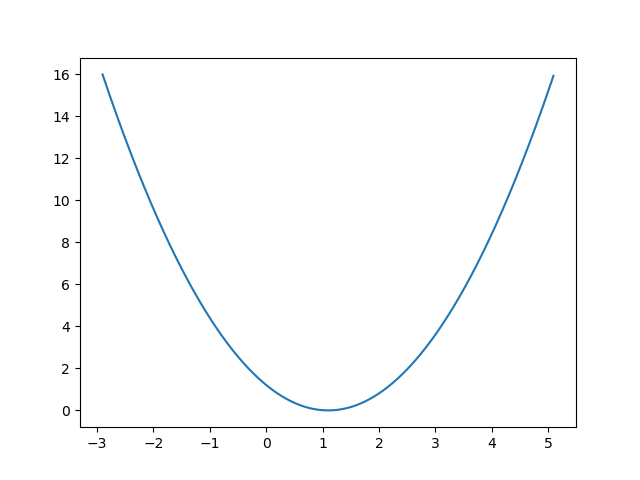

In [4]:
xgrid = -4. + 8. * np.arange(1000) / 1000. + 1.1
plt.plot(xgrid, func_parabola(xgrid))

In [5]:
a = 2. 
b = 3.
c = 4.
print(parabolic_step(func=func_parabola, a=a, b=b, c=c))

1.1000000000000008


Now let's try iterating this on a non-parabolic function, which is nevertheless convex.

In [6]:
def parabolic_minimize(func=None, astart=None, bstart=None, cstart=None,
                       tol=1.e-5, maxiter=10000):
    xgrid = -12. + 25. * np.arange(10000) / 10000. 
    plt.plot(xgrid, func(xgrid))
    a = astart
    b = bstart
    c = cstart
    bold = b + 2. * tol
    niter = 0
    while((np.abs(bold - b) > tol) & (niter < maxiter)):
        bold = b
        b = parabolic_step(func=func, a=a, b=b, c=c)
        if(b < bold):
            c = bold
        else:
            a = bold
        step = np.array([bold, b])
        plt.plot(step, func(step), color='black')
        plt.plot(step, func(step), '.', color='black')
        niter = niter + 1
    return(b)

In [7]:
def func_test(x):
    dx = x - 0.6
    return(0.1 * dx**4 - 0.5 * dx**3 + dx**2 + 2. * dx)

<IPython.core.display.Javascript object>


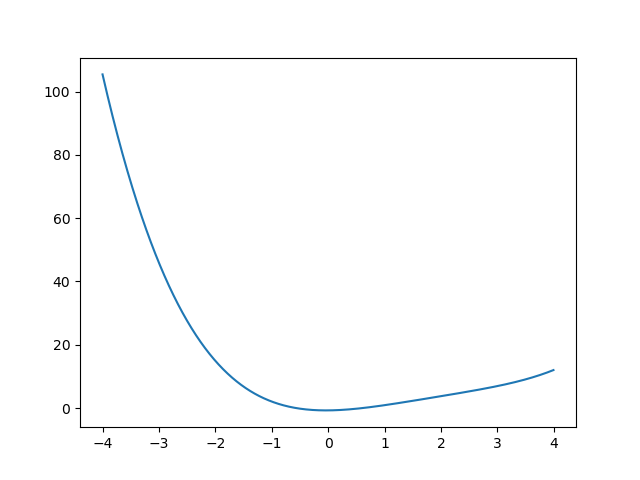

In [8]:
xgrid = -4. + 8. * np.arange(1000) / 1000. 
plt.plot(xgrid, func_test(xgrid))

<IPython.core.display.Javascript object>


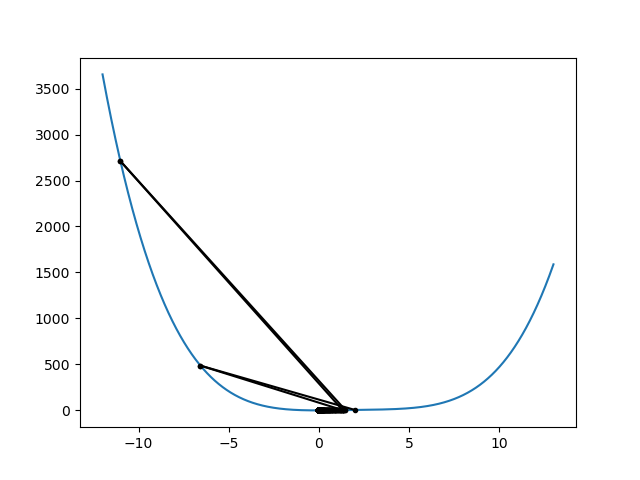

-0.04003502515313969

In [9]:
parabolic_minimize(func=func_test, astart=1., bstart=2., cstart=3.)

Now let's try a non-convex function.

In [10]:
def func_test2(x):
    dx = x - 0.6
    return(0.0003 * dx**4 - 0.03 * dx**2)

<IPython.core.display.Javascript object>


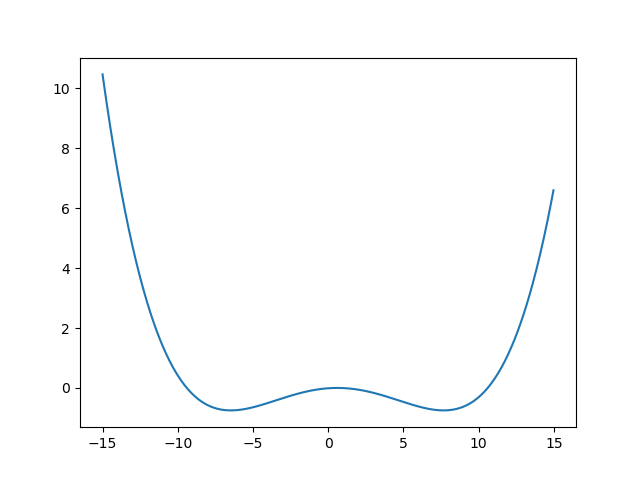

In [11]:
xgrid = -15. + 30. * np.arange(1000) / 1000. 
plt.plot(xgrid, func_test2(xgrid))

Note that this method does not distinguish between maximum and minimum!

<IPython.core.display.Javascript object>


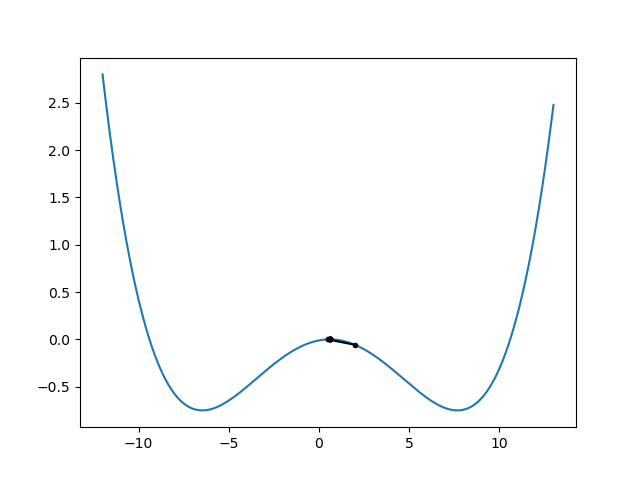

0.599999999998569

In [12]:
parabolic_minimize(func=func_test2, astart=1., bstart=2., cstart=3.)

It will find one minimum just fine.

<IPython.core.display.Javascript object>


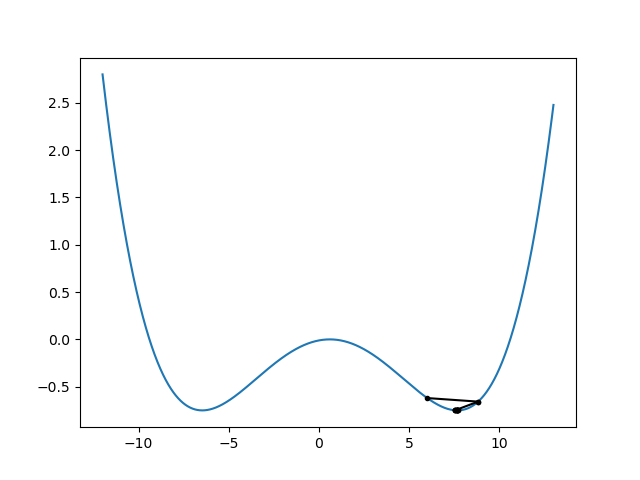

7.671067797053526

In [13]:
parabolic_minimize(func=func_test2, astart=5., bstart=6., cstart=7.)

What happens if we bracket both?

<IPython.core.display.Javascript object>


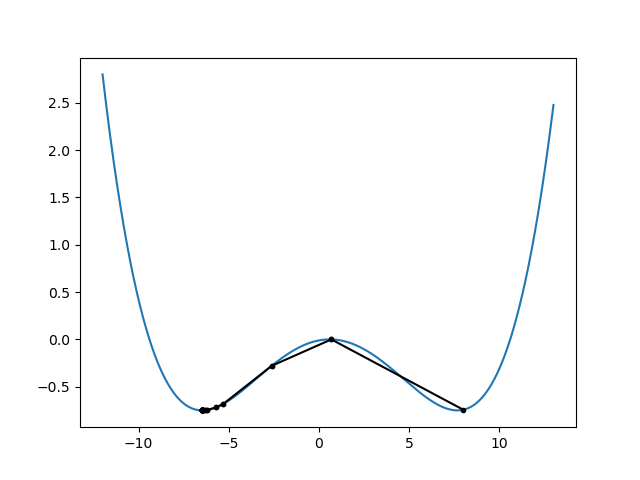

-6.471063467886177

In [14]:
parabolic_minimize(func=func_test2, astart=-9., bstart=8., cstart=10.)

## Golden section search

In [15]:
def golden(func=None, astart=None, bstart=None, cstart=None, tol=1.e-5):
    xgrid = -12. + 25. * np.arange(10000) / 10000. 
    plt.plot(xgrid, func(xgrid))
    gsection = (3. - np.sqrt(5)) / 2
    a = astart
    b = bstart
    c = cstart
    while(np.abs(c - a) > tol):
        if((b - a) > (c - b)):
            x = b
            b = b - gsection * (b - a)
        else:
            x = b + gsection * (c - b)
        step = np.array([b, x])
        plt.plot(step, func(step), color='black')
        plt.plot(step, func(step), '.', color='black')
        fb = func(b)
        fx = func(x)
        if(fb < fx):
            c = x
        else:
            a = b
            b = x 
    print(b)

<IPython.core.display.Javascript object>


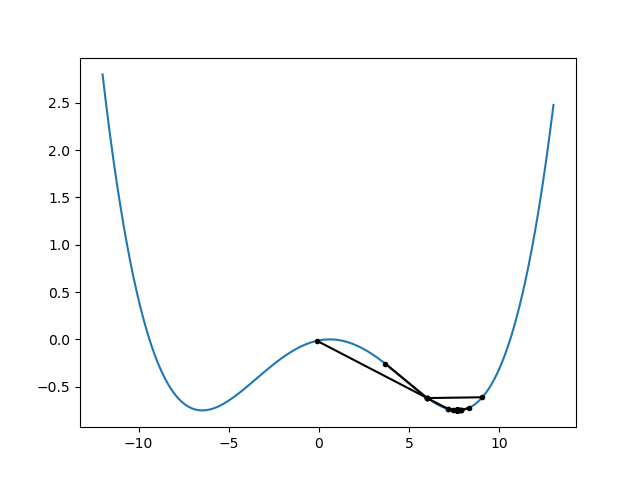

7.671067885027962


In [16]:
golden(func=func_test2, astart=-10., bstart=6., cstart=14.)